<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RNNregression_GRU_10seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt


In [44]:
# Load data

data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index","Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [45]:
# Preprocessing
data['Time_diff'] = data['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data['Latitude'].diff().fillna(0)
data['Lon_diff'] = data['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + 1e-5)
data.fillna(method='ffill', inplace=True)

In [46]:
# Normalize features
scaler = MinMaxScaler()
numeric_columns = ['Latitude', 'Longitude']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [47]:
def create_sequences(data, n_input=100, n_output=10):
    X, y = [], []
    for i in range(n_input, len(data) - n_output + 1):
        X.append(data.iloc[i-n_input:i][numeric_columns].values)
        y.append(data.iloc[i:i+n_output][['Latitude', 'Longitude']].values.flatten())
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = create_sequences(data)


In [48]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# PyTorch datasets and loaders
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        # Apply a linear layer and tanh activation to get the energy scores
        energy = torch.tanh(self.attn(encoder_outputs))
        attention = self.v(energy)  # Reduce the dimensionality to 1 to get the attention scores
        attention = attention.squeeze(2)  # Remove the singleton dimension
        return F.softmax(attention, dim=1)

class GRUAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(GRUAttentionModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_size, num_layers = 2, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_dim)  # The output layer for final predictions

    def forward(self, x):
        gru_out, _ = self.gru(x)  # gru_out shape: (batch, seq_len, hidden_size)
        attn_weights = self.attention(gru_out)  # Compute attention weights for each timestep
        context_vector = torch.bmm(attn_weights.unsqueeze(1), gru_out).squeeze(1)  # Apply attention to the GRU outputs
        output = self.fc(context_vector)  # Pass the context vector through the final output layer
        return output  # The model returns the final output directly

# Example usage
model = GRUAttentionModel(input_dim=2, hidden_size=64, output_dim=20).to('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


Epoch 1: Train Loss: 0.0015, Validation Loss: 0.0002
Saving model (epoch 1, loss improved from inf to 0.0002)
Epoch 2: Train Loss: 0.0002, Validation Loss: 0.0002
Saving model (epoch 2, loss improved from 0.0002 to 0.0002)
Epoch 3: Train Loss: 0.0002, Validation Loss: 0.0002
Saving model (epoch 3, loss improved from 0.0002 to 0.0002)
Epoch 4: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 5: Train Loss: 0.0002, Validation Loss: 0.0002
Saving model (epoch 5, loss improved from 0.0002 to 0.0002)
Epoch 6: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 7: Train Loss: 0.0002, Validation Loss: 0.0002
Saving model (epoch 7, loss improved from 0.0002 to 0.0002)
Epoch 8: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 9: Train Loss: 0.0002, Validation Loss: 0.0002
Saving model (epoch 9, loss improved from 0.0002 to 0.0002)
Epoch 10: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 11: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 12: Train Loss: 0.0002, Validation Loss: 0.0002
Savi

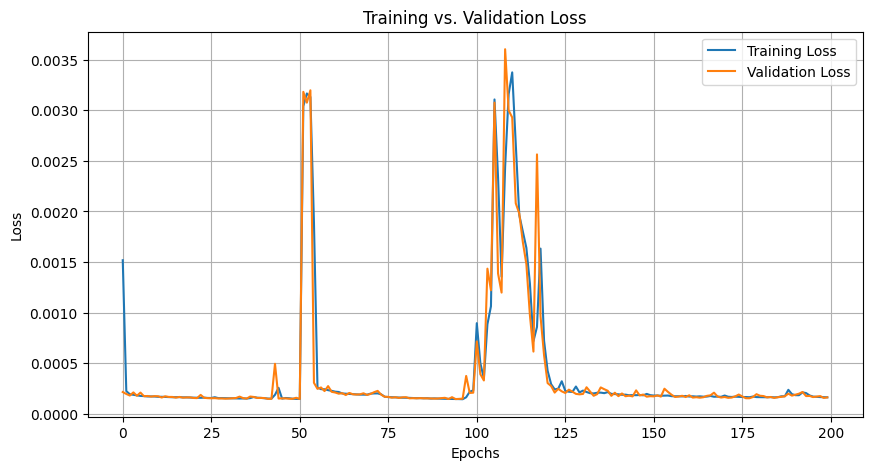

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, val_loader, num_epochs, device):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    # Lists to store loss per epoch for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Save the model if the validation loss has improved
        if avg_val_loss < best_val_loss:
            print(f'Saving model (epoch {epoch+1}, loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f})')
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = avg_val_loss

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization and training

train_and_validate(model, train_loader, test_loader, num_epochs=200, device=device)



In [52]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_model(model, test_loader, device, scaler):
    model.load_state_dict(torch.load('best_model.pth'))
    model.to(device)
    model.eval()

    all_past_data = []
    all_predictions = []
    all_actuals = []
    rmses = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 10, 2).cpu().numpy()
            actuals = y_batch.view(-1, 10, 2).cpu().numpy()
            past_data = X_batch[:, -100:, :2].view(-1, 100, 2).cpu().numpy()  # Assuming the last 100 points are relevant

            # Inverse transform to original scale
            predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).reshape(-1, 10, 2)
            actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).reshape(-1, 10, 2)
            past_data = scaler.inverse_transform(past_data.reshape(-1, 2)).reshape(-1, 100, 2)

            all_past_data.append(past_data)
            all_predictions.append(predictions)
            all_actuals.append(actuals)

            # Calculate RMSE for this batch and append
            batch_rmse = np.sqrt(mean_squared_error(predictions.reshape(-1, 2), actuals.reshape(-1, 2)))
            rmses.append(batch_rmse)

    average_rmse = np.mean(rmses)
    return all_past_data, all_actuals, all_predictions, rmses, average_rmse

# Example usage
all_past_data, all_actuals, all_predictions, rmses, average_rmse = evaluate_model(model, test_loader, device='cuda', scaler=scaler)
print("Average RMSE:", average_rmse)


Average RMSE: 0.014614213


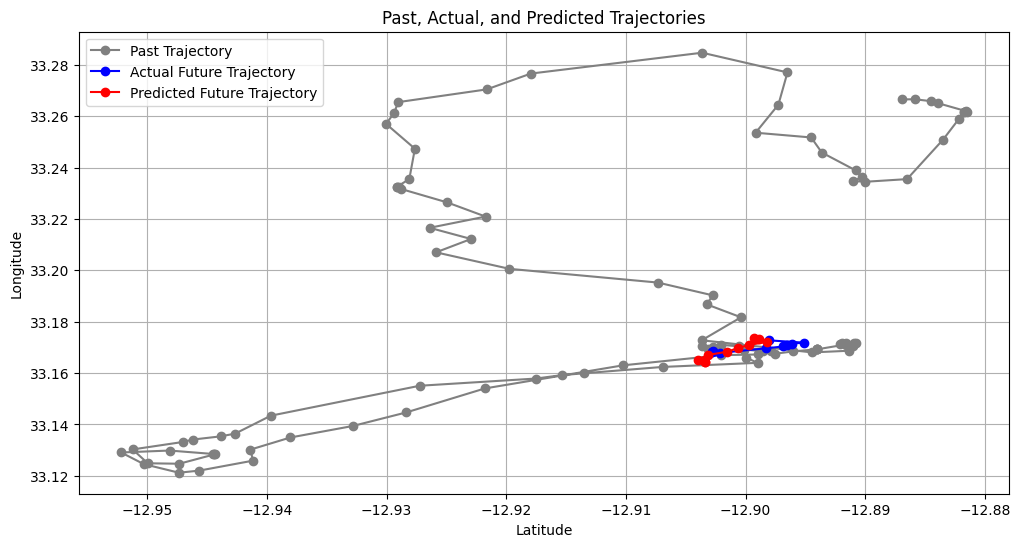

In [53]:
def plot_trajectories(past_data, actuals, predictions, index=0):
    plt.figure(figsize=(12, 6))
    # Plot the past trajectory
    plt.plot(past_data[index][0][:, 0], past_data[index][0][:, 1], 'gray', label='Past Trajectory', marker='o')
    # Plot the actual future trajectory
    plt.plot(actuals[index][0][:, 0], actuals[index][0][:, 1], 'bo-', label='Actual Future Trajectory')
    # Plot the predicted future trajectory
    plt.plot(predictions[index][0][:, 0], predictions[index][0][:, 1], 'ro-', label='Predicted Future Trajectory')

    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Past, Actual, and Predicted Trajectories')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_trajectories(all_past_data, all_actuals, all_predictions, index=0)
